In [1]:

#------------------------------------------------------------------------------------------------
#  Copyright (c) Shell Global Solutions International B.V. All rights reserved.
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

example_Fig09_USS_dpw+dpo+noSwz.py

# Fig. 09 from Berg et al. Simultaneous Determination of Relative Permeability and Capillary Pressure ... paper


Inverse Modeling of Unsteady-State (USS) Core Flooding Experiments in Special Core Analysis (SCAL)
for the purpose of extracting relative permeability and capillary pressure-saturation functions
                        
Created on 22.11.2021
by Harm Dijk, Steffen Berg

based on example004_USS_match_using_LET_and Skjaeveland_v001.py by Harm Dijk


* using LET model for relative permeability parameterization 
* using Skjaeveland model for capillary pressure parameterization
* match production curve, pressure drop vs. time
* NO saturation profiles included in match
* ONE flow rate ONLY

In [2]:

# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.0
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# Dependencies

In [3]:

import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

plt.rc('figure',facecolor='white')

from scallib001.displacementmodel1D2P001 import DisplacementModel1D2P
import scallib001.relpermlib001 as rlplib

# generate synthetic data set

In [4]:

# relperm and pc 

KRWE = 0.7
KROE = 1.0
SWC = 0.08
SORW = 0.14
NW = 2.5
NOW = 3.0

rlp_model1 = rlplib.Rlp2PCorey( SWC, SORW, NW, NOW, KRWE, KROE )


#Define the Skjaeveland Pc model
#extended with Masalmeh linear slope, parameter 'ci'


class Skjaeveland:
    
    def __init__(self,Swc,Sorw,Swi,cw,aw,ao,si=0):
        
        self.Swc = Swc
        self.Sorw = Sorw
        self.Swi  = Swi
        self.cw   = cw
        self.aw   = aw
        self.ao   = ao
        
        ssw = (  Swi-Swc )/(1-Swc )
        sso = (1-Swi-Sorw)/(1-Sorw)
        co = - cw*np.power(sso,ao)/np.power(ssw,aw)
        
        self.co = co
        self.si = si
        
    def calc(self,swv):
        Swc  = self.Swc
        Sorw = self.Sorw

        sov = 1-swv
        ssw = (swv-Swc )/(1-Swc )
        sso = (sov-Sorw)/(1-Sorw)
        
        l = (swv-self.Swi) * self.si * -1
    
        return self.cw/np.power(ssw,self.aw) + self.co/np.power(sso,self.ao) + l
    

#cpr_model1 = rlplib.CubicInterpolator( 
#    np.array([0.08,0.1,0.15,0.3,0.4,0.5,0.59,0.68,0.73,0.78,0.81,0.82,0.859,0.86]), 
#    np.array([-0.0,-0.001,-0.0054,-0.015,-0.0193,-0.0241,-0.0435,-0.0923,-0.1284,-0.18,-0.21,-0.24,-0.9,-2.0])
#    )

# make new pc model
AWI = 0.30
AOI = 0.60*1.5
CWI = 11.0/1000
SWI  = 0.13
CI = 0.0

Sorwi = SORW - 0.01
skj_model = Skjaeveland( SWC, Sorwi, SWI, CWI, AWI, AOI, CI )
EPS = 0.001  
n = 101
swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )
pcvi = skj_model.calc(swvi)
cpr_model1 = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )

# Plot Ground Truth relative permeability kr(Sw) and capillary pressure pc(Sw)

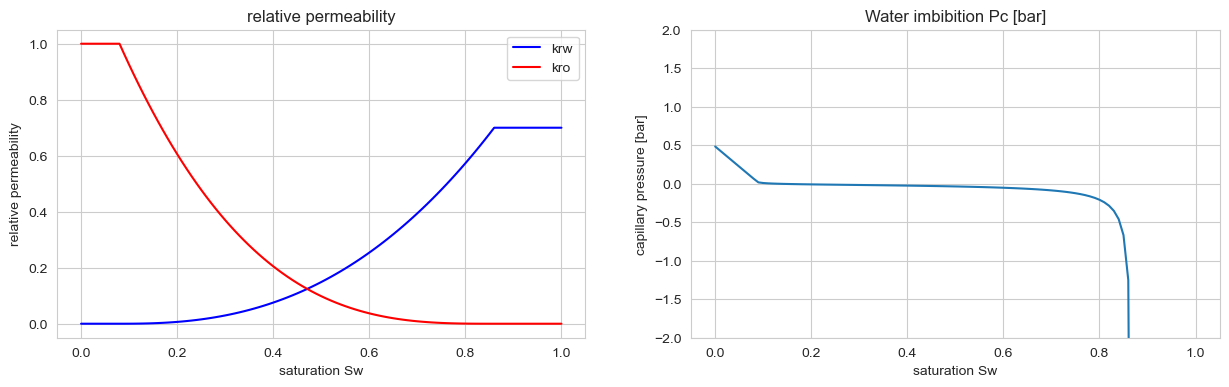

dict_keys(['self', 'r', 'xD', 'movie_tD', 'movie_dtD', 'movie_sw', 'movie_pw', 'movie_pn', 'movie_pcw', 'movie_delp', 'movie_flxw', 'movie_nr', 'x', 'sim_schedule', 'EPS', 'movie_period', 'movie_inj_rate_t', 'pore_volume', 'movie_dtime', 'movie_time', 'movie_inj_rate_w', 'movie_inj_rate_n', 'movie_prd_rate_w', 'movie_prd_rate_n', 'movie_inj_volume_w', 'movie_inj_volume_n', 'movie_prd_volume_w', 'movie_prd_volume_n', 'tss_table'])
Index(['TIME', 'DTIME', 'PVinj', 'tD', 'dtD', 'InjRate', 'PVInjRate',
       'FracFlowInj', 'FracFlowPrd', 'WATERInj', 'OILInj', 'WATERProd',
       'OILProd', 'CumWATERInj', 'CumOILInj', 'CumWATER', 'CumOIL', 'P_inj',
       'P_inj_wat', 'P_inj_oil', 'P_prod', 'P_prod_wat', 'P_prod_oil',
       'delta_P', 'delta_P_w', 'delta_P_o'],
      dtype='object')


In [5]:
swv = np.linspace(0,1,101)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1(swv), 'b', label='krw')
plt.plot( swv, rlp_model1.calc_kr2(swv), 'r', label='kro')
plt.legend();
plt.title('relative permeability');
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability');

plt.subplot(1,2,2)
plt.plot( swv, cpr_model1.calc(swv)[0] )
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');

plt.show()


# core and fluid data

exp_core_length    = 3.9       # cm
exp_core_area      = 12.0      # cm2
exp_permeability   = 100.0     # mDarcy
exp_porosity       = 0.18      # v/v
exp_sw_initial     = SWC       # v/v
exp_viscosity_w    = 1.0       # cP
exp_viscosity_n    = 1.0       # cP
exp_density_w      = 1000.0    # kg/m3
exp_density_n      = 1000.0 


# schedules

# T_End in dimensionless time
# tD_conv = (u.hour * u.cm**3/u.minute / (L*A*por)).to(u.minute/u.minute)

T_END = 2.0  # hours

Movie_times = np.linspace(0,T_END,100)

#Schedule = pd.DataFrame( 
#     [[0.0,    0.1, 1.0], 
#      [23.945, 0.5, 1.0], 
#      [29.08,  2.0, 1.0], 
#      [31.24,  5.0, 1.0]],
#    columns=['StartTime','InjRate','FracFlow'] )


Schedule = pd.DataFrame( 
     [[0.0,    0.1, 1.0]],
    columns=['StartTime','InjRate','FracFlow'] )
#times in min, injrate in cm3/min


#Define 1D2P displacement model

model1 = DisplacementModel1D2P(    
    NX=50,
    core_length    = exp_core_length,
    core_area      = exp_core_area,
    permeability   = exp_permeability,
    porosity       = exp_porosity,
    sw_initial     = exp_sw_initial,
    viscosity_w    = exp_viscosity_w,
    viscosity_n    = exp_viscosity_n,
    density_w      = exp_density_w,
    density_n      = exp_density_n,
    rlp_model      = rlp_model1,
    cpr_model      = cpr_model1,
    time_end       = T_END,
    rate_schedule  = Schedule,
    movie_schedule = Movie_times, # Same timesteps as experimental data
 )


#Solve the model with the initial gues relperm and capcurve models
#note that first time code needs to be called by numba, takes some time
model1.solve();

#Keep the results
result_exp = model1.results

print(result_exp.keys())
print(result_exp.tss_table.keys())

#plot model results
#1D2P timestep summary data stored in 'tss_table', with column names similar to MoReS

# Plot pressure drop, production curve and saturation profiles generated from ground truth

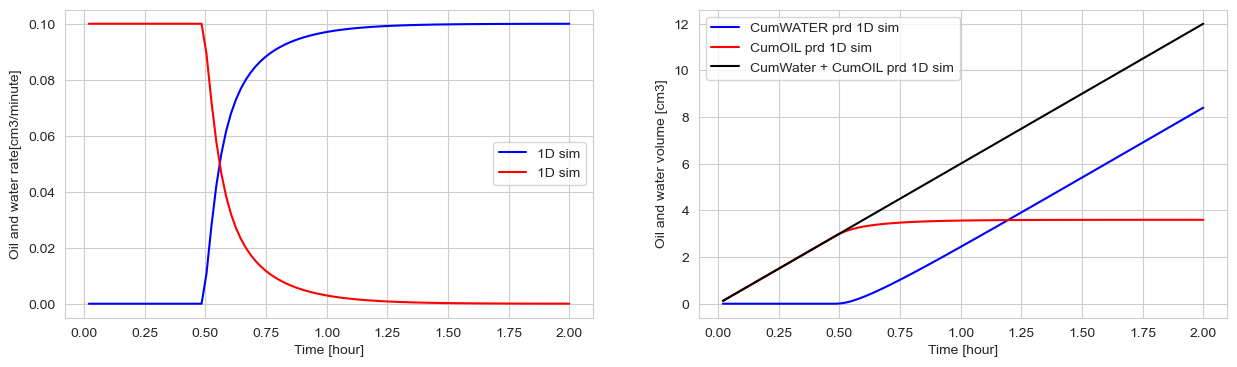

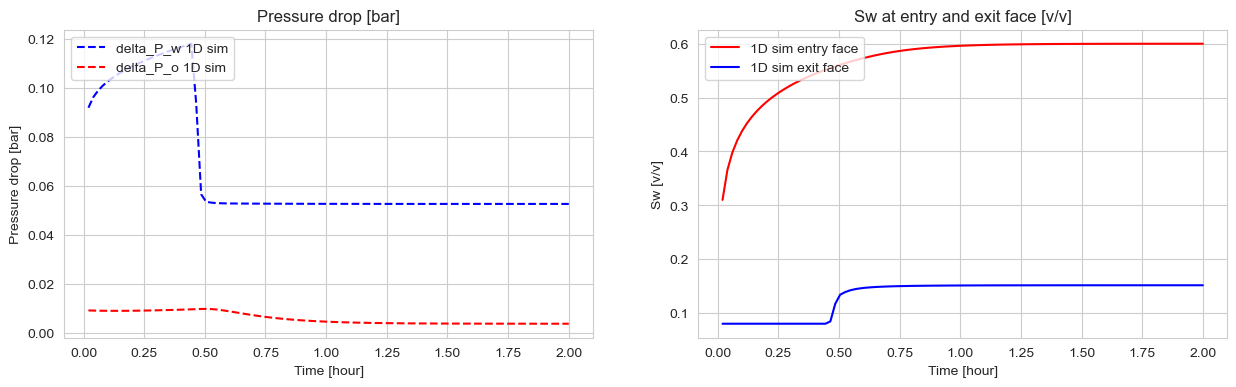

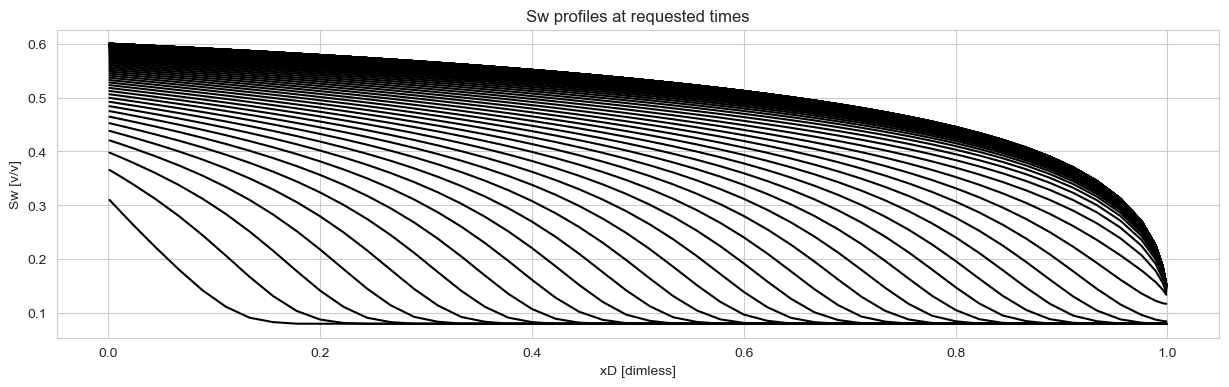

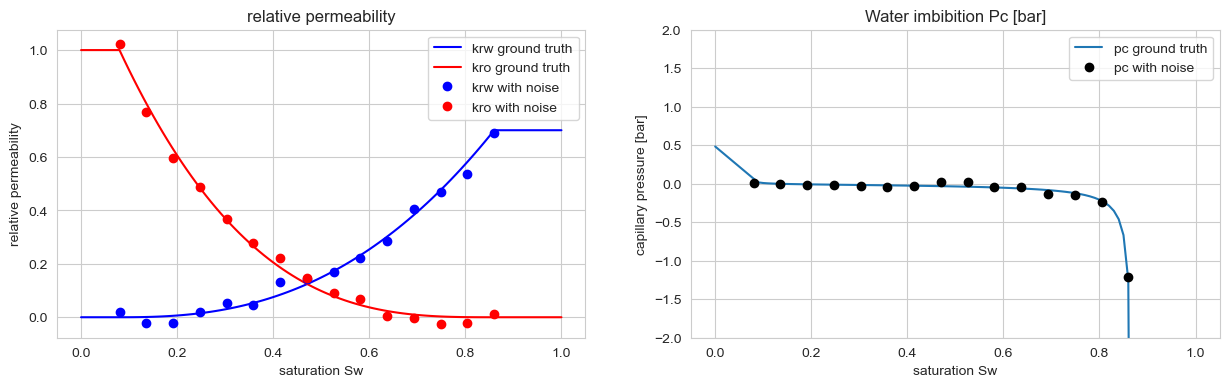

In [6]:

plt.figure(figsize=(15,4))
tss = result_exp.tss_table
plt.subplot(1,2,1)
plt.plot( tss.TIME, tss.WATERProd, 'b', label='1D sim' )
plt.plot( tss.TIME, tss.OILProd, 'r', label='1D sim' )
plt.legend();
plt.ylabel('Oil and water rate[cm3/minute]')
plt.xlabel('Time [hour]');
plt.subplot(1,2,2)
plt.plot( tss.TIME, tss.CumWATER, 'b', label='CumWATER prd 1D sim' )
plt.plot( tss.TIME, tss.CumOIL, 'r', label='CumOIL prd 1D sim' )
plt.plot( tss.TIME, tss.CumWATER+tss.CumOIL, 'black', label='CumWater + CumOIL prd 1D sim' )
plt.legend();
plt.ylabel('Oil and water volume [cm3]')
plt.xlabel('Time [hour]');
plt.show()


plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
tss = result_exp.tss_table
plt.plot( tss.TIME, tss.delta_P_w,'b--', label='delta_P_w 1D sim')
plt.plot( tss.TIME, tss.delta_P_o,'r--', label='delta_P_o 1D sim' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop [bar]')
plt.legend(loc='upper left');
plt.subplot(1,2,2)
plt.plot( result_exp.movie_time, result_exp.movie_sw[:, 0],'r',   label='1D sim entry face')
plt.plot( result_exp.movie_time, result_exp.movie_sw[:,-1],'b',   label='1D sim exit face' )
plt.legend(loc='upper left');
plt.title('Sw at entry and exit face [v/v]')
plt.xlabel('Time [hour]');
plt.ylabel('Sw [v/v]');
plt.show()

plt.figure(figsize=(15,4))
plt.plot( result_exp.xD, result_exp.movie_sw.T, 'k');
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles at requested times');
plt.show()



# add noise to relperm and pc models (starting values for fit)
Nkr=15
swvNkr = np.linspace(SWC,1-SORW,Nkr)
Indexv=np.linspace(1,Nkr,Nkr)

krerrlevel=0.1   # add 10% noise
np.random.seed(123)
krexpdata={'INDEX':Indexv,'Sat':swvNkr,'kr1':(rlp_model1.calc_kr1(swvNkr)+krerrlevel*(np.random.rand(Nkr)-0.5)),'kr2':(rlp_model1.calc_kr2(swvNkr)+krerrlevel*(np.random.rand(Nkr)-0.5))}
krexp=pd.DataFrame(data=krexpdata)

pcerrlevel=krerrlevel*np.abs(cpr_model1.calc(swvNkr)[0]).max()
pcexpdata=krexpdata={'INDEX':Indexv,'Sat':swvNkr,'Pc':(cpr_model1.calc(swvNkr)[0]+pcerrlevel*(np.random.rand(Nkr)-0.5))}
pcexp=pd.DataFrame(data=pcexpdata)

swv = np.linspace(0,1,101)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1(swv), 'b', label='krw ground truth')
plt.plot( swv, rlp_model1.calc_kr2(swv), 'r', label='kro ground truth')
plt.plot( krexp.Sat, krexp.kr1, 'o', color='blue', label='krw with noise')
plt.plot( krexp.Sat, krexp.kr2, 'o', color='red', label='kro with noise')
plt.legend();
plt.title('relative permeability');
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability');

plt.subplot(1,2,2)
plt.plot( swv, cpr_model1.calc(swv)[0], label='pc ground truth')
plt.plot( pcexp.Sat, pcexp.Pc, 'o', color='black', label='pc with noise')
plt.ylim(-2,2)
plt.title('Water imbibition Pc [bar]');
plt.xlabel('saturation Sw'); plt.ylabel('capillary pressure [bar]');
plt.legend();
plt.show()

# Add noise to ground truth

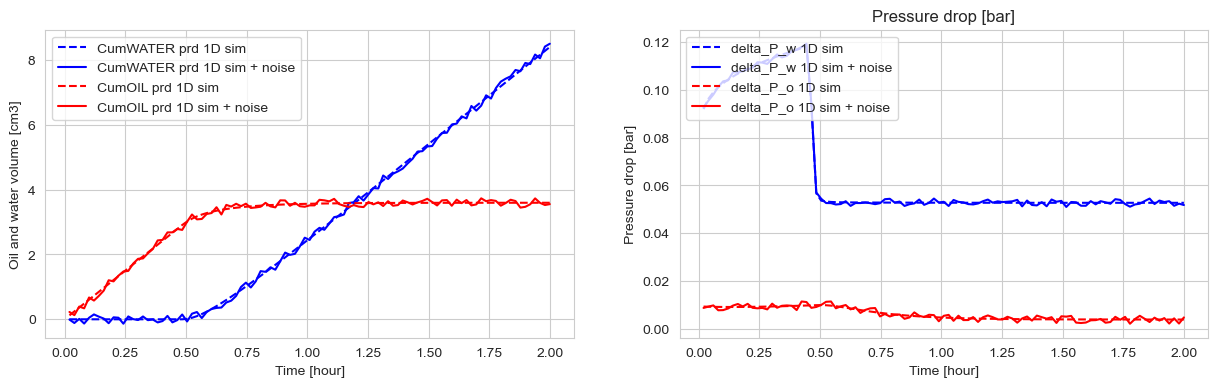

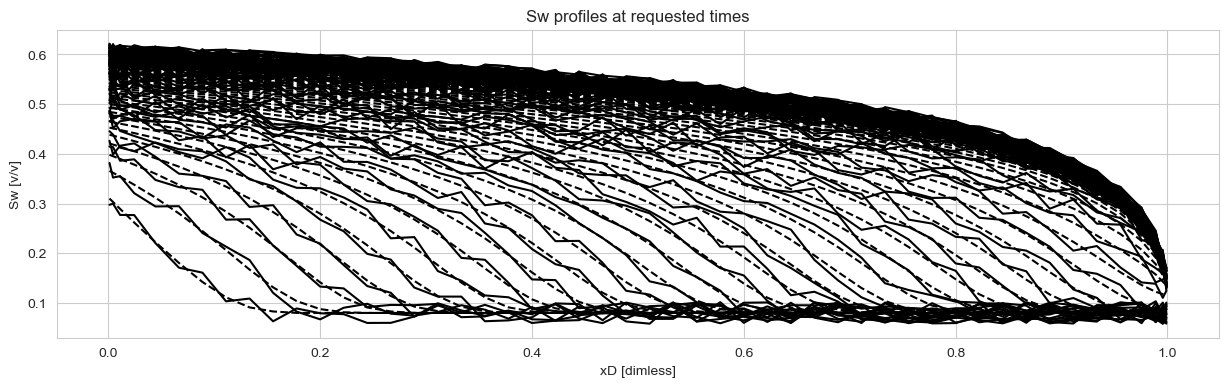

In [7]:

# add some noise to "experimental data"
Nrandt  = len(result_exp.tss_table)
Nrandx = len(result_exp.xD)

errlevel=0.1   # add 10% noise
dpmean= (tss.delta_P_w.mean()+tss.delta_P_o.mean())/2
Cummean = (tss.CumWATER.mean()+tss.CumOIL.mean())/2
Swmean = result_exp.movie_sw.T.mean()

np.random.seed(123)
dpwerr = tss.delta_P_w + dpmean*errlevel*(np.random.rand(Nrandt)-0.5)
dpoerr = tss.delta_P_o + dpmean*errlevel*(np.random.rand(Nrandt)-0.5)

CumWATERerr = tss.CumWATER + Cummean*errlevel*(np.random.rand(Nrandt)-0.5)
CumOILerr = tss.CumOIL + Cummean*errlevel*(np.random.rand(Nrandt)-0.5)


# this works but adds same error to each time step at same position which is a bit artificial
#Swproferr = result_exp.movie_sw.T + Swmean * errlevel * (np.random.rand(Nrandx)-0.5)[:,np.newaxis]

Swerrmaxtrix=np.full_like(result_exp.movie_sw.T,1)
for i in range(0,result_exp.movie_sw.T.shape[1]):
   Swerrmaxtrix[:,i]=Swmean * errlevel * (np.random.rand(Nrandx)-0.5)
Swproferr = result_exp.movie_sw.T+Swerrmaxtrix
Swaverr = np.average(Swproferr,axis=0)


plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( tss.TIME, tss.CumWATER, 'b--', label='CumWATER prd 1D sim' )
plt.plot( tss.TIME, CumWATERerr, 'b', label='CumWATER prd 1D sim + noise' )
plt.plot( tss.TIME, tss.CumOIL, 'r--', label='CumOIL prd 1D sim' )
plt.plot( tss.TIME, CumOILerr, 'r', label='CumOIL prd 1D sim + noise' )
plt.legend();
plt.ylabel('Oil and water volume [cm3]')
plt.xlabel('Time [hour]');
plt.subplot(1,2,2)
tss = result_exp.tss_table
plt.plot( tss.TIME, tss.delta_P_w,'b--', label='delta_P_w 1D sim')
plt.plot( tss.TIME, dpwerr,'b', label='delta_P_w 1D sim + noise')
plt.plot( tss.TIME, tss.delta_P_o,'r--', label='delta_P_o 1D sim' );
plt.plot( tss.TIME, dpoerr,'r', label='delta_P_o 1D sim + noise' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop [bar]')
plt.legend(loc='upper left');
plt.show()

plt.figure(figsize=(15,4))
plt.plot( result_exp.xD, result_exp.movie_sw.T, 'k--');
plt.plot( result_exp.xD, Swproferr, 'k');
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles at requested times');
plt.show()


# writing to expdataHIS data frame

# without noise
# expdataHIS = result_exp.tss_table

#with noise

Indext=np.linspace(1,Nrandt,Nrandt)
OIIP=exp_core_length*exp_core_area*exp_porosity*(1-exp_sw_initial)

# Defnition of dp_switch_time
# dp_sim = np.where( dp_time<dp_switch_time, dp_o_sim, dp_w_sim )
dperr=dpwerr    # dp_switch_time = 0 --> dp= dp_w


expdataHISdata={'INDEX':Indext,'TIME':tss.TIME, 'PVinj':tss.PVinj, 'Sw':Swaverr, 'RF':(CumOILerr/OIIP), 'CumOIL':CumOILerr, 'DeltaPressure':dperr, 'dpw':dpwerr, 'dpo':dpoerr, 'tD':result_exp.tss_table.tD}
expdataHIS=pd.DataFrame(data=expdataHISdata)


# writing saturation profiles to 

sattimelistn = [1,4,8,12,20]
expdataHISsattimes = tss.TIME[sattimelistn]
satprofileindex = np.linspace(1,len(result_exp.xD),len(result_exp.xD))
expdataHISsatprofilesdata = {'INDEX':satprofileindex, 'Distance':result_exp.xD * exp_core_length, 'xD':result_exp.xD}
for i in range(len(sattimelistn)):
    expdataHISsatprofilesdata['Profile'+str(i+1)]=result_exp.movie_sw.T[:,sattimelistn[i]]
expdataHISsatprofiles=pd.DataFrame(data=expdataHISsatprofilesdata)



# inverse modeling: start with initial guess

In [8]:

#Fit LET model to the estimate from the experimental data
#to have starting point for fitting of USS experiment below

from lmfit import Minimizer, Parameters, report_fit

class RlpMatchObjective1:

    def __init__(self, kr_data ):

        self.kr_data = kr_data
        
        self.sw_data = kr_data.Sat.values
        self.kw_data = kr_data.kr1.values
        self.ko_data = kr_data.kr2.values

        self.errorbar = 0.02
        
        self.counter = 0

    def __call__(self, params):
        '''This function is called by the optimizer; calculate mismatch vector.'''
        
        self.counter += 1

        # Build new relperm model from current parameters
        rlpmodeli = self.params_to_rlpmodel( params )
         
        # Calculate relperm values at data sw values    
        kw, ko, _, _ = rlpmodeli.calc(self.sw_data)

        y      = np.hstack( [kw,           ko          ] ) 
        y_data = np.hstack( [self.kw_data, self.ko_data] )
        
        return (y-y_data)/self.errorbar

    def params_to_rlpmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']

        rlpmodel = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                    Lo, Eo, To, krwe, kroe)
        
        return rlpmodel
    


print("Experimental data kr")    
print(krexp)


KRWE = krexp.kr1.max()
KROE = krexp.kr2.max()
SWC  = krexp.Sat.min()
SORW = 1-krexp.Sat.max()
NW   = 2.5
NOW  = 3.0

params_LET = Parameters()
params_LET.add('Swc',  value=SWC,  vary=False)
params_LET.add('Sorw', value=SORW, min=0.05, max=0.45, vary=True)
params_LET.add('krwe', value=KRWE, min=0.05, max=1.10, vary=True)
params_LET.add('kroe', value=KROE, min=0.05, max=1.10, vary=True)
params_LET.add('Lw', value=NW,   min=1.5,  max=5.0, vary=True)
params_LET.add('Ew', value=0.01, min=1e-4, max=50.0, vary=True)
params_LET.add('Tw', value=1.50, min=1.0,  max=5.0, vary=True)
params_LET.add('Lo', value=NOW,  min=1.5,  max=5.0, vary=True)
params_LET.add('Eo', value=0.01, min=1e-4, max=50.0, vary=True)
params_LET.add('To', value=1.50, min=1.0,  max=5.0, vary=True)

Kr_data = krexp
rlpmatchobjective1 = RlpMatchObjective1( Kr_data )

# Check that match objective function works
rlpmatchobjective1( params_LET )

result_LET = Minimizer(rlpmatchobjective1, params_LET ).least_squares(diff_step=1e-4,verbose=2)

# for making the iteration stop earlier add ftol=1e-4
#result_LET = Minimizer(rlpmatchobjective1, params_LET ).least_squares(diff_step=1e-4,verbose=2,ftol=1e-4)

Experimental data kr
    INDEX       Sat       kr1       kr2
0     1.0  0.080000  0.019647  1.023800
1     2.0  0.135714 -0.020432  0.768905
2     3.0  0.191429 -0.021915  0.597283
3     4.0  0.247143  0.020011  0.488213
4     5.0  0.302857  0.052491  0.367614
5     6.0  0.358571  0.045669  0.279111
6     7.0  0.414286  0.132246  0.221532
7     8.0  0.470000  0.142227  0.147446
8     9.0  0.525714  0.170877  0.089820
9    10.0  0.581429  0.221156  0.067798
10   11.0  0.637143  0.286159  0.005620
11   12.0  0.692857  0.405959 -0.003981
12   13.0  0.748571  0.469993 -0.024258
13   14.0  0.804286  0.537584 -0.020264
14   15.0  0.860000  0.689804  0.013098
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8344e+03                                    6.46e+06    
       1              2         3.1080e+03      6.73e+03       5.44e-01       8.72e+05    
       2              3         1.3611e+03      1.75e+03       4.4

# print parameters from fit of LET model to relperm guess

In [9]:

report_fit(result_LET)

print('Fitting LET function to kr guess')
result_LET.params.pretty_print()

rlpmodel_LET_fit = rlpmatchobjective1.params_to_rlpmodel( result_LET.params ) 

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 3986
    # data points      = 30
    # variables        = 9
    chi-square         = 30.0502113
    reduced chi-square = 1.43096244
    Akaike info crit   = 18.0501693
    Bayesian info crit = 30.6609457
[[Variables]]
    Swc:   0.08 (fixed)
    Sorw:  0.13999136 +/- 0.12106807 (86.48%) (init = 0.14)
    krwe:  0.67798408 +/- 0.11173055 (16.48%) (init = 0.6898044)
    kroe:  1.00936828 +/- 0.02382316 (2.36%) (init = 1.0238)
    Lw:    1.61502104 +/- 0.80037995 (49.56%) (init = 2.5)
    Ew:    2.73417674 +/- 2.51869734 (92.12%) (init = 0.01)
    Tw:    1.04513551 +/- 0.78720297 (75.32%) (init = 1.5)
    Lo:    1.83992095 +/- 0.80998272 (44.02%) (init = 3)
    Eo:    3.41008425 +/- 1.34850643 (39.54%) (init = 0.01)
    To:    1.00461105 +/- 0.19619262 (19.53%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Sorw, krwe) = -0.9773
    C(Lw, Ew)     = -0.9756
    C(Ew, Tw)     = +0.9

# Plot fit of LET model to relperm guess

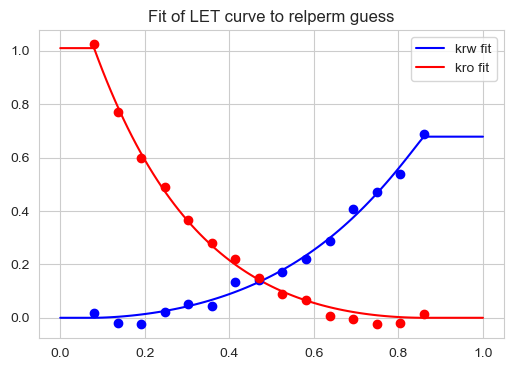

In [10]:

swv = np.linspace(0,1,101)
plt.figure(figsize=(6,4))
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro');
plt.legend();
plt.title('Fit of LET curve to relperm guess');
plt.show()

# plot comparison pressure drop for water and oil

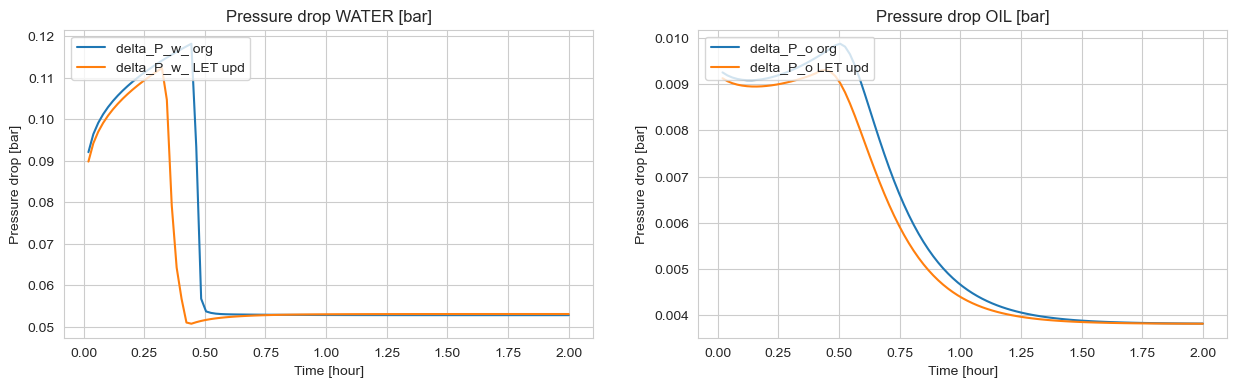

In [11]:

# Check whether the fitted kr model runs and compare with ground truth
# Assign LET relperm model to 1D2P and solve again

model1.rlp_model = rlpmodel_LET_fit
#model1.rlp_model = rlp_model1

result_upd1 = model1.solve().results

tss1 = result_exp.tss_table
tss2 = result_upd1.tss_table

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( tss1.TIME, tss1.delta_P_w,'-', label='delta_P_w_ org')
plt.plot( tss2.TIME, tss2.delta_P_w,'-', label='delta_P_w_ LET upd')
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop WATER [bar]')
plt.legend(loc='upper left');
plt.subplot(1,2,2)
plt.plot( tss1.TIME, tss1.delta_P_o,'-',   label='delta_P_o org')
plt.plot( tss1.TIME, tss2.delta_P_o,'-',   label='delta_P_o LET upd' );
plt.xlabel('Time [hour]');
plt.ylabel('Pressure drop [bar]');
plt.title('Pressure drop OIL [bar]')
plt.legend(loc='upper left');
plt.show()




    

#Define USS match objective function
#match pressure drop and Sw profiles
#switch from oil to water pressure at dp_switch_time
#weigh pressure drop vs saturation data

class USSMatchObjective1:

    def __init__(self, 
                 model, 
                 dp_weight=1, op_weight=1, sw_weight=1,
                 dp_data=None, dp_error=None, 
                 dp_switch_time = 0,

                 op_data=None, op_error=None,
                 
                 sw_profile_times=None, 
                 sw_profile_data=None, sw_error=None,

                ):

        self.model = model
        
        self.dp_weight = dp_weight
        self.dp_data   = dp_data
        self.dp_error  = dp_error
       
        self.dp_switch_time = dp_switch_time
        
        self.op_weight = op_weight
        self.op_data   = op_data
        self.op_error  = op_error
        
        self.sw_weight        = sw_weight
        self.sw_profile_times = sw_profile_times
        self.sw_profile_data  = sw_profile_data
        self.sw_error = sw_error
        
        self.counter = 0

    def __call__(self, params):
        '''This function is called by the optimizer; calculate mismatch vector.'''
        
        self.counter += 1

        # Build new relperm model from current parameters
        rlpmodeli = self.params_to_rlpmodel( params )
 
        # Build new capillary model from current parameters
        cprmodeli = self.params_to_cprmodel( params )

        model = self.model
        
        model.rlp_model = rlpmodeli
        model.cpr_model = cprmodeli
        
        results = model.solve().results
        
        
        
        tss = results.tss_table
        
        #--- Pressure match
        
        # Interpolate simulation to measurement TIME
        dp_time = self.dp_data.TIME.values
        
        dp_w_sim = np.interp( dp_time, tss.TIME.values, tss.delta_P_w.values )
        dp_o_sim = np.interp( dp_time, tss.TIME.values, tss.delta_P_o.values )
        
        
        
        # this is for USS experiments where only the total dp is measured        
        dp_switch_time = self.dp_switch_time
        dp_sim = np.where( dp_time<dp_switch_time, dp_o_sim, dp_w_sim )
        dp_dat = self.dp_data.DeltaPressure.values ###delta_P_w.values  # ???
        dp_mismatch = (dp_sim - dp_dat) / self.dp_error
               
        # this is for Digital Rock simulations where we have both dpw and dpo  
        dpw_dat = self.dp_data.dpw.values 
        dpo_dat = self.dp_data.dpo.values 
        dp_mismatch = (dp_w_sim - dpw_dat) / self.dp_error + (dp_o_sim - dpo_dat) / self.dp_error
        
        
        #--- Oil production match
        op_time = self.op_data.TIME.values
        op_dat  = self.op_data.CumOIL.values
        
        op_sim = np.interp( op_time, tss.TIME.values, tss.CumOIL.values )
        
        op_mismatch = (op_sim-op_dat)/self.op_error
        
        
        #--- Saturation profile match 
        sw_time = self.sw_profile_times
        
        xD, sw_dat, sw_sim = get_his_sim_profiles( sw_time, 
                                                   self.sw_profile_data, 
                                                   results )
        
        sw_mismatch = (sw_sim - sw_dat) / self.sw_error
        
        
        
        # ---- add up different mismatch contributions 
        
        mismatch = []
        
        dp_weight = self.dp_weight
        mismatch.append( dp_mismatch.flatten() * dp_weight )
        
        op_weight = self.op_weight
        mismatch.append( op_mismatch.flatten() * op_weight )
        
        sw_weight = self.sw_weight
        mismatch.append( sw_mismatch.flatten() * sw_weight )
            
        mismatch = np.hstack( mismatch )
        
        # Keep current state for debugging purposes
        class dictn(dict):
            def __getattr__(self,k):
                return self[k]
            
        self.current = dictn(locals())
        
        return mismatch

    def params_to_rlpmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']

        rlp_model = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                     Lo, Eo, To, krwe, kroe)
        
        return rlp_model

    def params_to_cprmodel( self, params ):
        
        v = params.valuesdict()
        
        Swc  = v['Swc']
        Sorw = v['Sorw']
        Swi  = v['Swi']
        cwi  = v['cwi']
        awi  = v['awi']
        aoi  = v['aoi']
        ci   = v['ci']
        
        # We take Sorw for Pc to the right of the relperm Sorw
        Sorwi = Sorw - 0.01
        
        skj_model = Skjaeveland( Swc, Sorwi, Swi, cwi, awi, aoi, ci )

        # We give the Skjaevland Pc model to the simulator as a cubic interpolation model
        EPS = 0.001
    
        n = 101

        swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )

        pcvi = skj_model.calc(swvi)

        cpr_model = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )

        return cpr_model
    
    
#Some procedures to facilate comparison of Sw profiles model-data, used in objective function
def get_his_sw_profiles( sw_profile_data ):

    #profhis = sw_profile_data[:-1]  # drop last row, 
    profhis = sw_profile_data
    
    xpos_his = profhis.xD.values
    
    sw_his = []
    for c in profhis.columns:
        if c.startswith('Profile'):
            sw_his.append( profhis[c].values.copy() )
    sw_his = np.array( sw_his )
    
    return xpos_his, sw_his

def get_sim_sw_profiles( model_result, his_profile_times, his_xD_position ):
    
    model_xD    = model_result.xD
    movie_time  = model_result.movie_time 
    movie_sw    = model_result.movie_sw
    
    # Identify which movie index corresponds to historical sample time
    time_index = [np.argmin( np.abs(v-movie_time) ) for v in his_profile_times]
    
    # Interpolate simulation sw at data position for each sample time
    sw_sim = []
    for i in time_index:
        swi = np.interp( his_xD_position, model_xD, movie_sw[i] )
        sw_sim.append(swi)   
    sw_sim = np.array( sw_sim )
    
    return sw_sim    
    
def get_his_sim_profiles( sw_profile_times, sw_profile_data, model_result ):
    
    xpos_his, sw_his = get_his_sw_profiles( sw_profile_data )
    
    # get simulated sw profiles at data sample locations and data sample times
    sw_sim = get_sim_sw_profiles( model_result, sw_profile_times, xpos_his )
    
    return xpos_his, sw_his, sw_sim


#Define some analysis plots for match quality

def plot_rlp_cpr(matchobj, suptitle, params=None ):
    
    swv = np.linspace(0,1,101)

    if params is None:
        current_rlp_model = matchobj.current.rlpmodeli
        current_cpr_model = matchobj.current.cprmodeli
    else:
        current_rlp_model = matchobj.params_to_rlpmodel( params )
        current_cpr_model = matchobj.params_to_cprmodel( params )

    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    plt.plot( swv, rlp_model1.calc_kr1(swv), label='krw start' )
    plt.plot( swv, rlp_model1.calc_kr2(swv), label='kro start' )

    plt.plot( krexp.Sat, krexp.kr1, 'ko', label='krw start table' )
    plt.plot( krexp.Sat, krexp.kr2, 'ko', label='kro start table')

    plt.plot( swv, current_rlp_model.calc_kr1(swv), 'b--', label='krw match')
    plt.plot( swv, current_rlp_model.calc_kr2(swv), 'r--', label='kro match')

    plt.legend(loc='best')
    
    plt.title('Water and oil relperm')

    plt.subplot(1,2,2)
    plt.plot( swv, cpr_model1.calc(swv)[0], label='Pc start' )

    plt.plot( pcexp.Sat, pcexp.Pc, 'ko', label='Pc start table');

    swv_max = pcexp.Sat.max() + 0.01
    
    plt.plot( swv[swv<swv_max], current_cpr_model.calc(swv[swv<swv_max])[0], 'b--', label='Pc match' )

    plt.legend(loc='best')
    plt.ylim(-2,2)
    plt.title('Water imbibition Pc [bar]');
    plt.show()

       
def plot_match_dp(matchobj,suptitle, draw_phase_pressures=False):
        
    current = matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
        
    plt.subplot(1,2,1)
    #plt.plot( current.dp_time, current.dp_sim, 'r', label='match')
    #plt.plot( current.dp_time, current.dp_dat, 'k', alpha=0.4, label='data')
    plt.plot( current.dp_time, current.dpw_dat, 'b-', label='dP water exp')
    plt.plot( current.dp_time, current.dpo_dat, 'r-', label='dP oil exp')

    if draw_phase_pressures:
        plt.plot( tss.TIME, tss.delta_P_w, 'b--', label='dP water sim')
        plt.plot( tss.TIME, tss.delta_P_o, 'r--', label='dP oil sim')
    
    plt.legend(loc='best')
    plt.title('Pressure drop [bar]')
    plt.ylabel('Delta P[bar]')
    plt.xlabel('Time [hour]')
    
    plt.subplot(1,2,2)
    plt.title('Water + Oil Pressure drop standardized mismatch: (sim-data)/stderr')
    plt.plot( current.dp_time, current.dp_mismatch, color='black')
    plt.axhline(+1,color='k',ls='--')
    plt.axhline(-1,color='k',ls='--');
    
    plt.xlabel('Time [hour]');
    plt.show()

    
def plot_xplot(matchobj,suptitle):
    
    current = matchobj.current
    
    plt.figure(figsize=(15,6))
    
    plt.suptitle(suptitle, fontsize=16)

    plt.subplot(1,2,1)
    plt.plot( current.dp_dat, current.dp_sim, '.')
    plt.plot( [0,0.5], [0,.5], 'k--')
    plt.xlabel('Delta P experiment [bar]')
    plt.ylabel('Delta P sim [bar]')
    plt.title('Delta P x-plot');

    plt.subplot(1,2,2)
    plt.plot( current.sw_dat.flatten(), current.sw_sim.flatten(), '.')
    plt.plot( [0,1], [0,1], 'k--');
    plt.xlabel('Sw profile experiment [v/v]')
    plt.ylabel('Sw profile sim [v/v]');
    plt.title('Sw x-plot');
    plt.show()
    

def plot_error_press(matchobj,suptitle):
    
    current = matchobj.current
    
    
    npts = len(current.mismatch)
    
    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    plt.title('Water + Oil Pressure drop standardized mismatch: (sim-data)/stderr')
    plt.plot( current.dp_time, current.dp_mismatch )
    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('Time [hour]')
 
    plt.subplot(1,2,2)
    plt.title('Pressure drop cumulative mismatch SSQ')
    plt.plot( current.dp_time, np.cumsum( (current.dp_mismatch)**2)/npts )
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Time [hour]');
    plt.show()
    

def plot_error_production(matchobj,suptitle):
    
    current = matchobj.current 
    
    npts = len(current.mismatch)
    
    plt.figure(figsize=(15,4))

    plt.suptitle( suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    plt.title('Oil production standardized mismatch: (sim-data)/stderr')
    plt.plot( current.op_time, current.op_mismatch )
    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('Time [hour]')
 
    plt.subplot(1,2,2)
    plt.title('Oil production cumulative mismatch SSQ')
    plt.plot( current.op_time, np.cumsum( (current.op_mismatch)**2)/npts )
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Time [hour]');
    plt.show()
    
    
def plot_error_sw_profile(matchobj,suptitle):
    
    current = matchobj.current
    
    
    npts = len(current.mismatch)
    
    ntime,nx = current.sw_mismatch.shape
    
    xD_all = np.tile( current.xD, ntime )
    sw_mismatch_all = current.sw_mismatch.flatten(order='C')
    
    dummy = np.arange(sw_mismatch_all.size)
       
    xedges = np.array( [v*nx for v in np.arange(ntime+1)] )
    xmid   = (xedges[1:] + xedges[:-1])*0.5

    plt.figure(figsize=(15,8))

    plt.suptitle( suptitle )
    
    plt.subplot(2,1,1)
    
    
    plt.title('Sw profile standardized mismatch: (sim-data)/stderr')
    plt.plot( dummy, sw_mismatch_all )
    
    for v in xedges:
        plt.axvline(v,color='k',ls='--',lw=1,alpha=0.4)       
    plt.xticks(xmid)
    plt.gca().set_xticklabels( np.arange(ntime)+1 )

    plt.axhline(-1,color='k',ls='--')
    plt.axhline(+1,color='k',ls='--')

    plt.xlabel('xD [dimless] for each flow period')
    plt.ylabel('Mismatch [dimless]')
    
    plt.subplot(2,1,2)
    plt.title('Sw profile cumulative mismatch SSQ')
    plt.plot( dummy, np.cumsum( (sw_mismatch_all)**2)/npts )

    for v in xedges:
        plt.axvline(v,color='k',ls='--',lw=1,alpha=0.4)       
    plt.xticks(xmid)
    plt.gca().set_xticklabels( np.arange(ntime)+1 )
    
    plt.axhline(+1,color='k',ls='--')
    plt.xlabel('Position & Time [hour]');
    plt.ylabel('Cumulative SSQ');
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    
def plot_match_sw_profile(matchobj,suptitle):
    
    current = matchobj.current
    
    plt.figure(figsize=(14,12))

    plt.suptitle(suptitle,fontsize=16)
    
    counter=1

    for sws,swh in zip( current.sw_sim, current.sw_dat):

        plt.subplot(4,4,counter); counter+=1

        plt.plot( current.xD, sws, 'r')
        plt.plot( current.xD, swh, 'k.')
        
        plt.ylim(0,1)
        
        if counter>len(current.sw_sim)-4+1:
            plt.xlabel('xD [-]')
            
        if plt.gca().is_first_col():
            plt.ylabel('Sw [v/v]');
        
        # TODO generalize time
        v = current.sw_time[counter-2]
        plt.title('Sw at %7.3f hour'%v)

    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    
def plot_match_dp_production(uss_matchobj,suptitle,draw_phase_pressures=True):
    current = uss_matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
    
    plt.subplot(1,2,1)
    #plt.plot( current.dp_time, current.dp_sim, 'r', label='match')
    #plt.plot( current.dp_time, current.dp_dat, 'k', alpha=0.4, label='data')
    plt.plot( current.dp_time, current.dpw_dat, 'b-', label='dP water exp')
    plt.plot( current.dp_time, current.dpo_dat, 'r-', label='dP oil exp')

    if draw_phase_pressures:
        plt.plot( tss.TIME, tss.delta_P_w, 'b--', label='dP water sim')
        plt.plot( tss.TIME, tss.delta_P_o, 'r--', label='dP oil sim')
    
    plt.legend(loc='best')
    plt.title('Pressure drop [bar]')
    plt.ylabel('Delta P[bar]')
    plt.xlabel('Time [hour]')
    
    plt.subplot(1,2,2)
    plt.title('Oil production')
    plt.plot( current.op_time, current.op_dat, 'k-', label='Oil data')
    plt.plot( current.op_time, current.op_sim, 'r--', label='Oil match')
    plt.xlabel('Time [hour]');   
    plt.ylabel('Oil production [cm3]')
    plt.show()
    

def plot_match_production(uss_matchobj,suptitle):
    
    current = uss_matchobj.current
    
    tss = current.results.tss_table

    plt.figure(figsize=(15,4))

    plt.suptitle(suptitle, fontsize=16 )
        
    plt.subplot(1,2,1)
    plt.title('Oil production')
    plt.plot( current.op_time, current.op_dat, 'k-', label='Oil data')
    plt.plot( current.op_time, current.op_sim, 'r--', label='Oil match')
    plt.xlabel('Time [hour]');   
    plt.ylabel('Oil production [cm3]')
    
    plt.subplot(1,2,2)
    
    plt.plot( current.op_time, current.op_mismatch, 'r' )
    plt.title('Oil production standardized mismatch: (sim-data)/stderr')
    plt.plot( current.op_time, current.op_mismatch, 'r')
    plt.axhline(+1,color='k',ls='--')
    plt.axhline(-1,color='k',ls='--');
    
    plt.xlabel('Time [hour]');
    plt.show()
    
    
def plot_match_all(matchobj,suptitle):
    
    plot_rlp_cpr( matchobj, suptitle )
    plt.show()
    plot_match_dp( matchobj, suptitle, draw_phase_pressures=True )
    plt.show()
    plot_error_press( matchobj, suptitle )
    plt.show()
    plot_error_sw_profile(matchobj, suptitle )
    plt.show()
    plot_xplot( matchobj, suptitle )
    plt.show()
    plot_match_sw_profile( matchobj, suptitle )
    plt.show()
    
    
def plot_match_all_uss(matchobj,suptitle):
    
    plot_rlp_cpr( matchobj, suptitle )
    plt.show()
    plot_match_dp_production( matchobj, suptitle)
    plt.show()
    plot_match_dp( matchobj, suptitle, draw_phase_pressures=True )
    plt.show()
    plot_error_press( matchobj, suptitle )
    plt.show()
    plot_match_production(matchobj, suptitle )
    plt.show()
    plot_error_production( matchobj, suptitle )
    plt.show()
    plt.show()
    plot_xplot( matchobj, suptitle )
    plt.show()

# print starting values for fit parameters

Swc 0.08 -inf inf False
Sorw 0.13999135670888688 0.05 0.45 True
krwe 0.6779840830708307 0.05 1.1 True
kroe 1.009368281546991 0.05 1.1 True
Lw 1.6150210379851115 1.5 5.0 True
Ew 2.7341767378605795 0.0001 50.0 True
Tw 1.0451355103727498 1.0 5.0 True
Lo 1.8399209489062882 1.5 5.0 True
Eo 3.4100842478358935 0.0001 50.0 True
To 1.004611053349954 1.0 5.0 True
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Eo        3.41   0.0001       50     None     True     None     None
Ew       2.734   0.0001       50     None     True     None     None
Lo        1.84      1.5        5     None     True     None     None
Lw       1.615      1.5        5     None     True     None     None
Sorw      0.14     0.05     0.45     None     True     None     None
Swc       0.08     -inf      inf     None    False     None     None
Swi       0.13      0.1      0.3     None     True     None     None
To       1.005        1        5     None     True     None     None
Tw       1.045       

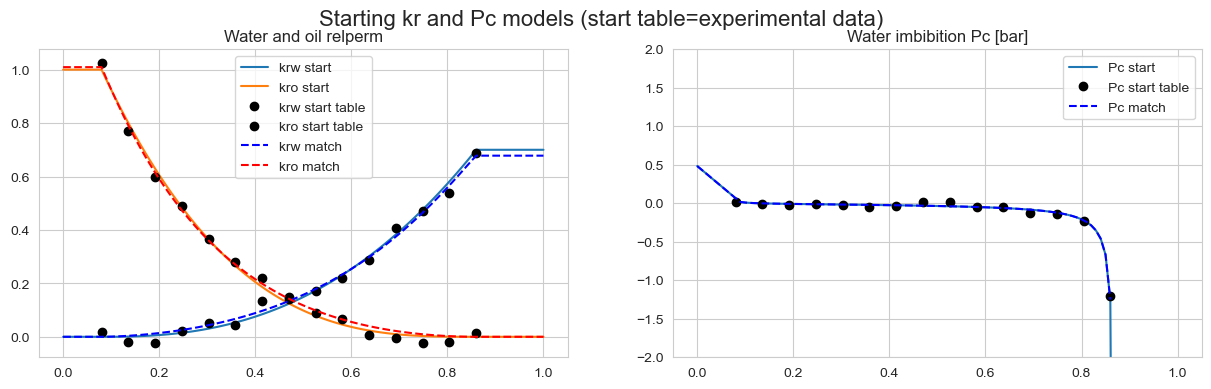

In [12]:
   
#Define match parameters for kr and Pc
    
params_pckr = Parameters()


# copy the parameter from the LET model fit to starting experimental data table data

for p in result_LET.params.values():
    print(p.name,p.value,p.min,p.max,p.vary)
    params_pckr.add(p.name,value=p.value,min=p.min,max=p.max,vary=p.vary)
    
    
# Add the Pc parameters

#AWI2 = 0.30
#AOI2 = 0.60*1.5
#CWI2 = 11.0/1000
#SWC2  = 0.08
#SWI2  = 0.13

#same starting values as ground truth
AWI2 = AWI
AOI2 = AOI
CWI2 = CWI
SWC2  = SWC
SWI2  = SWI

params_pckr.add('cwi', value=CWI2,     min=0.2*CWI2,     max=CWI2*2.0, vary=True  )
params_pckr.add('awi', value=AWI2,     min=AWI2*0.5,     max=AWI2*3.0, vary=True )
params_pckr.add('aoi', value=AOI2,     min=AOI2*0.5,     max=AOI2*3.0, vary=True  )
params_pckr.add('ci',  value=CI,       min=0.0,          max=CWI2*20,  vary=True  )
params_pckr.add('Swi', value=SWI2,     min=0.1,          max=0.3,      vary=True )

params_pckr.pretty_print()

#fix Ew, Eo, Tw, To
params_pckr['Ew'].vary=False
params_pckr['Eo'].vary=False
params_pckr['Tw'].vary=False
params_pckr['To'].vary=False



#Define match objective to match both dp and sw
#switch from oil pressure to water pressure at 46.4 hour
#equal weight to dp and sw

uss_matchobj = USSMatchObjective1( 
    model=model1,
    dp_weight=1, op_weight=1, sw_weight=0,
    dp_data=expdataHIS,
    dp_error=0.01,
    op_data =expdataHIS, 
    op_error = 0.05,
    sw_profile_times=expdataHISsattimes,
    sw_profile_data =expdataHISsatprofiles,
    sw_error = 0.01,
    dp_switch_time=0, # switch from delta_P_o to delta_P_w at this time
)


#Check that objective function works

uss_matchobj( params_pckr )


#Check starting relperm and capillary pressure model vs experimental data tables

plot_rlp_cpr( uss_matchobj, 'Starting kr and Pc models (start table=experimental data)', params=params_pckr)

# Execute fit

In [13]:

#Excute fit
result_pckr = Minimizer(uss_matchobj, params_pckr ).least_squares(diff_step=1e-4,verbose=2)

# write error report
print('\n\n\n')
report_fit(result_pckr)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6463e+02                                    1.14e+04    
       1              2         1.9779e+02      3.67e+02       9.20e-02       1.65e+03    
       2              3         1.7161e+02      2.62e+01       1.12e-01       8.71e+02    
       3              4         1.5345e+02      1.82e+01       1.42e-01       6.79e+02    
       4              5         1.4297e+02      1.05e+01       1.52e-01       9.84e+01    
       5              6         1.4152e+02      1.45e+00       1.43e-01       1.05e+02    
       6              7         1.4127e+02      2.55e-01       1.44e-01       3.61e+01    
       7              8         1.4118e+02      8.36e-02       4.32e-02       3.86e+00    
       8              9         1.4099e+02      1.90e-01       3.74e-01       8.49e+01    
       9             10         1.4089e+02      1.03e-01       3.17e-02       8.14e-01    

# Print table with fit results

In [14]:

result_pckr.params.pretty_print()


#Evaluate objective at best point

uss_matchobj( result_pckr.params );

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Eo        3.41   0.0001       50        0    False     None     None
Ew       2.734   0.0001       50        0    False     None     None
Lo         1.5      1.5        5    12.91     True     None     None
Lw       2.348      1.5        5    1.127     True     None     None
Sorw    0.1553     0.05     0.45    3.258     True     None     None
Swc       0.08     -inf      inf        0    False     None     None
Swi     0.1336      0.1      0.3   0.1027     True     None     None
To       1.005        1        5        0    False     None     None
Tw       1.045        1        5        0    False     None     None
aoi     0.4963     0.45      2.7    8.567     True     None     None
awi     0.2181     0.15      0.9    2.889     True     None     None
ci     0.01906        0     0.22   0.7431     True     None     None
cwi    0.02192   0.0022    0.022   0.6214     True     None     None
kroe       1.1     0.05      1.1

# Make Plots

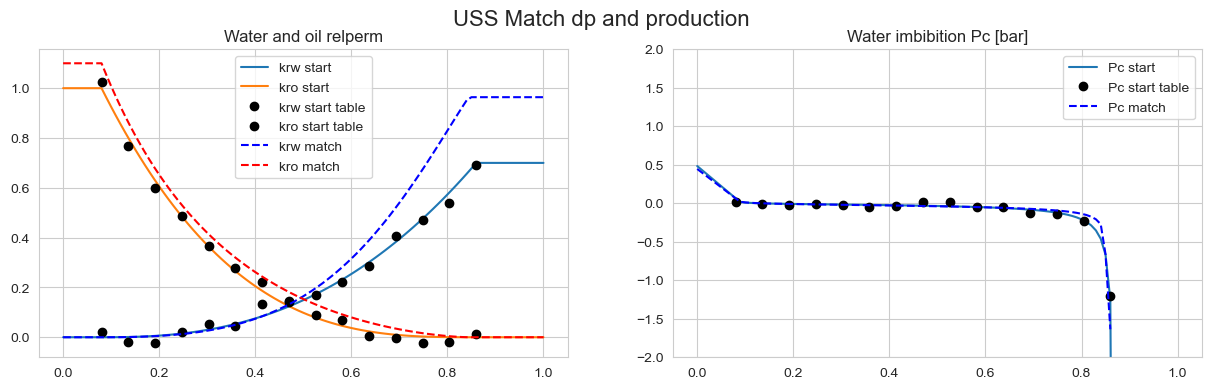

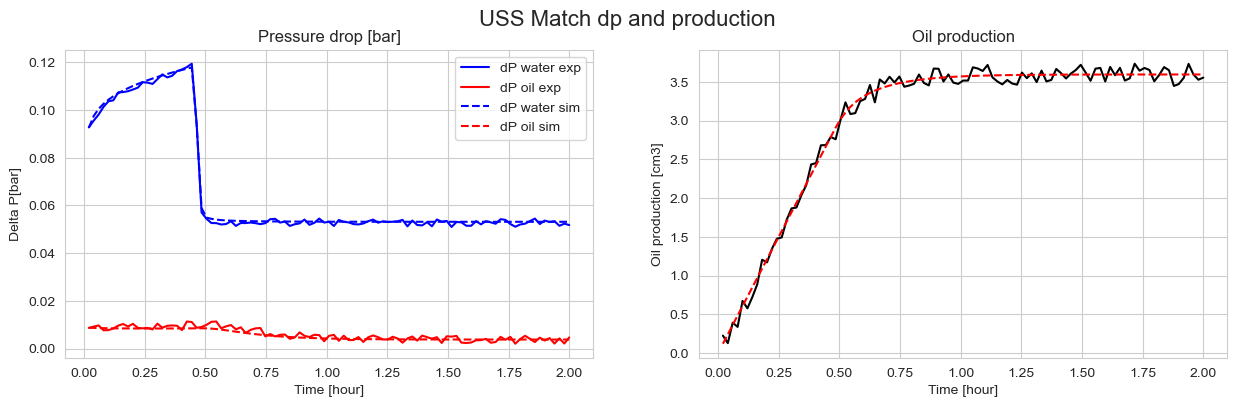

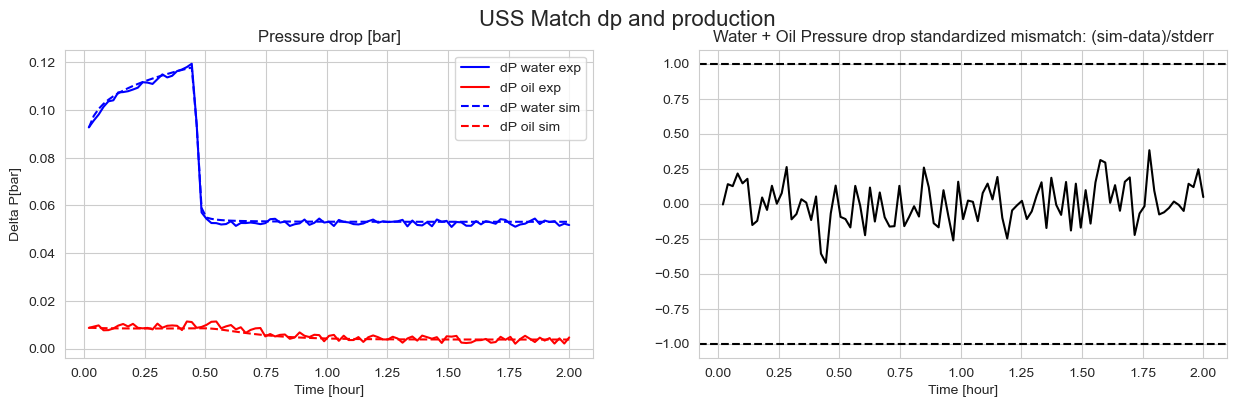

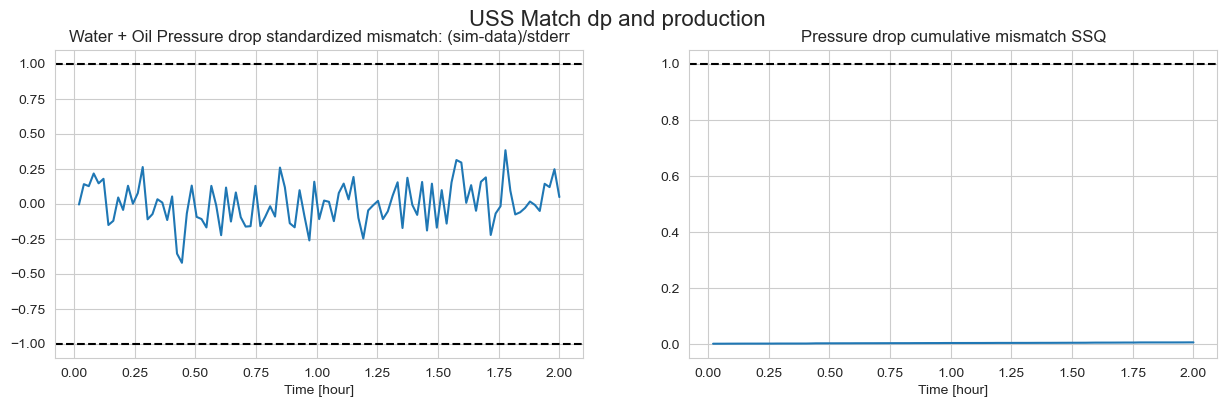

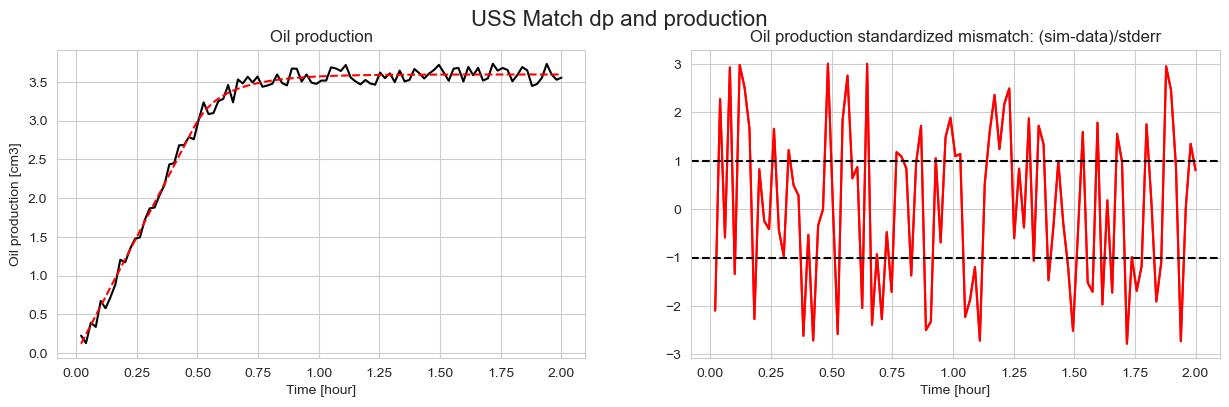

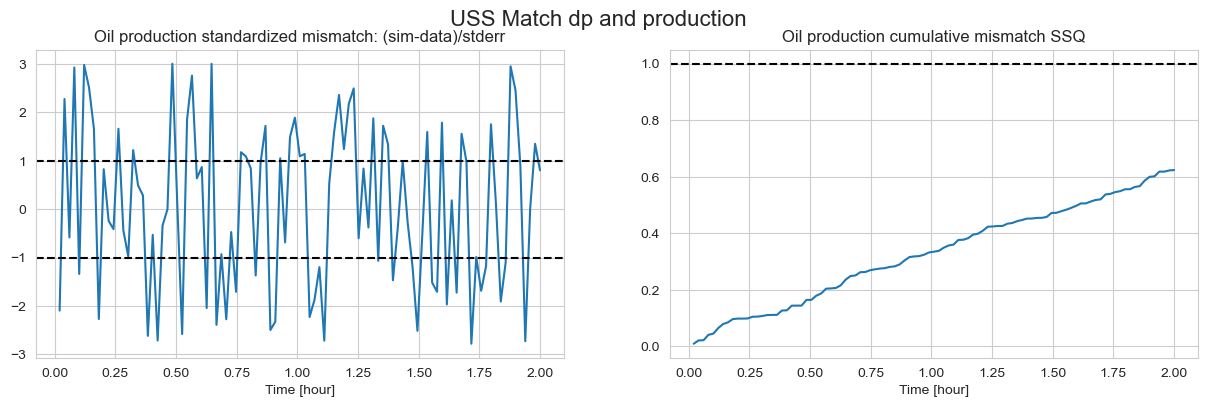

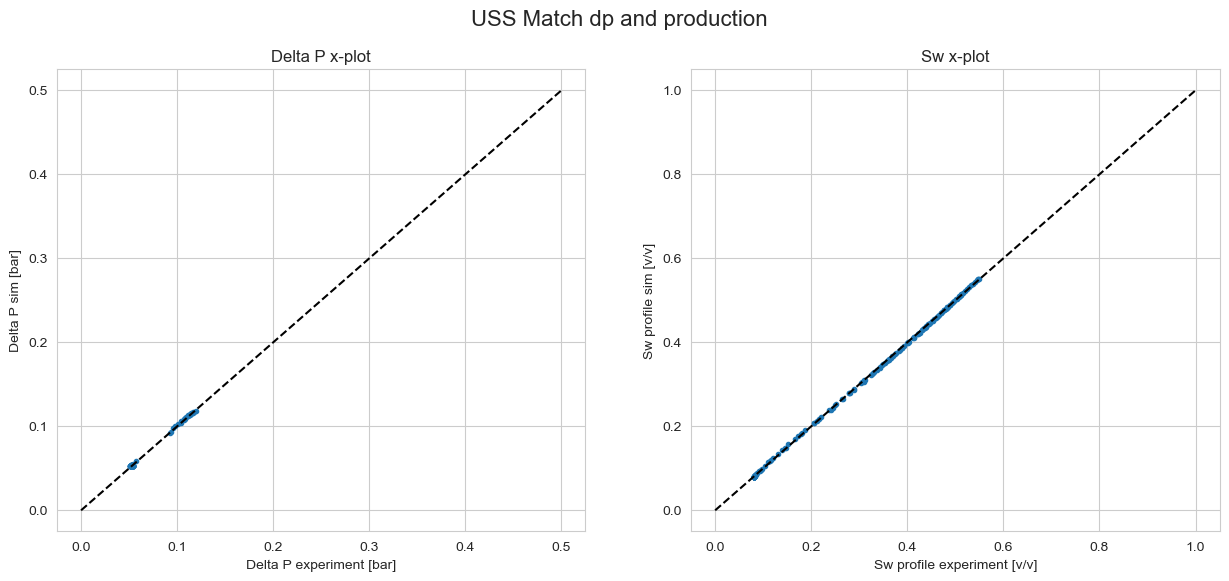

In [15]:
plot_match_all_uss(uss_matchobj,'USS Match dp and production')
#plot_match_all(uss_matchobj,'USS Match dp and production')

# Plot Saturation change along plug for each flooding period

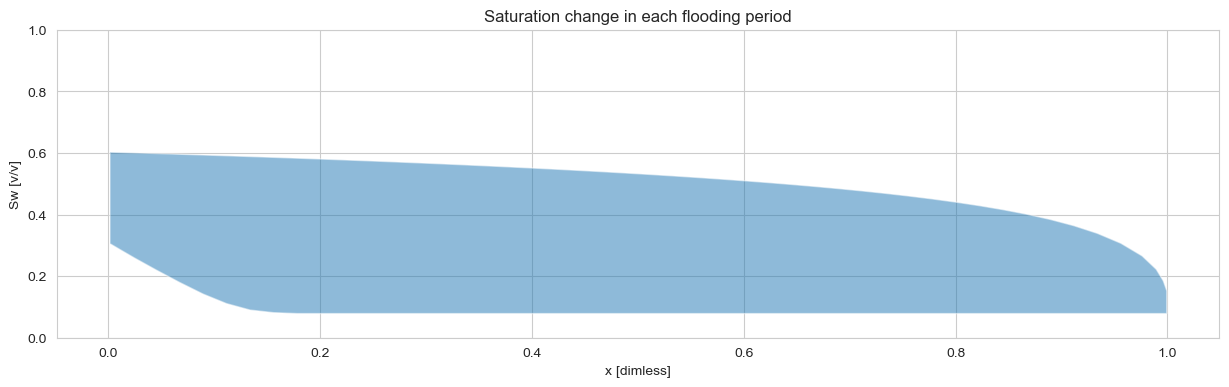

In [16]:

#Saturation change along plug for each flooding period

plt.figure(figsize=(15,4))

result1 = model1.results

lw = result1.movie_sw[0,:]
for i in range(1,result1.movie_period.max()+1):
    hg = result1.movie_sw[result1.movie_period==i][-1,:]
    plt.fill_between( result1.xD,lw,hg,alpha=0.5)
    lw = hg

plt.ylim(0,1);
plt.xlabel('x [dimless]')
plt.ylabel('Sw [v/v]');

plt.title('Saturation change in each flooding period');
plt.show()

# Plot match of saturation profiles

C:\Users\Steffen.Berg\AppData\Local\Temp\ipykernel_11420\917998031.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot( result_exp.xD, Swproferr, 'k', color='gray',label='experimental data');


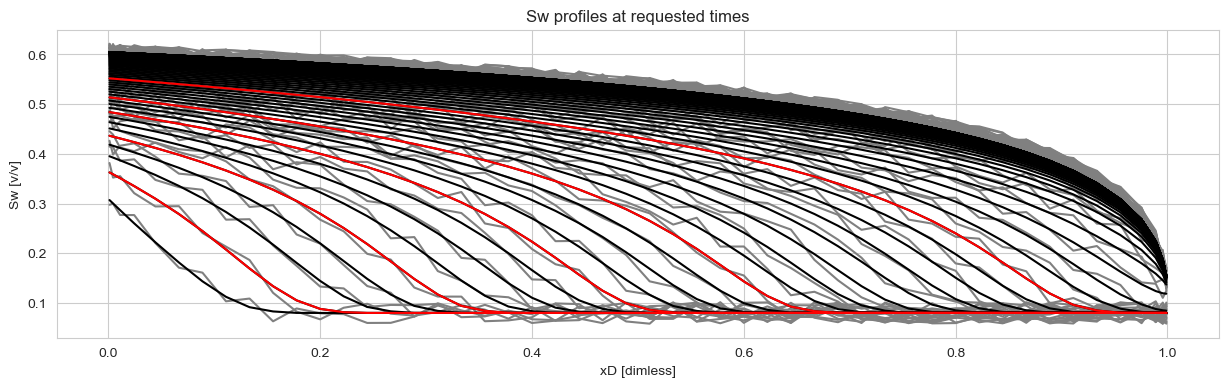

In [17]:

plt.figure(figsize=(15,4))
plt.plot( result_exp.xD, Swproferr, 'k', color='gray',label='experimental data');
plt.plot( result1.xD, result1.movie_sw.T, 'k',label='match');
for i in range(0,len(sattimelistn)):
    plt.plot( result1.xD, result1.movie_sw.T[:,sattimelistn[i]], 'r-',label='match');
plt.xlabel('xD [dimless]')
plt.ylabel('Sw [v/v]')
plt.title('Sw profiles at requested times');
#plt.legend()
plt.show()



# Plot error ranges

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Eo        3.41   0.0001       50        0    False     None     None
Ew       2.734   0.0001       50        0    False     None     None
Lo         1.5      1.5        5    12.91     True     None     None
Lw       2.348      1.5        5    1.127     True     None     None
Sorw    0.1553     0.05     0.45    3.258     True     None     None
Swc       0.08     -inf      inf        0    False     None     None
Swi     0.1336      0.1      0.3   0.1027     True     None     None
To       1.005        1        5        0    False     None     None
Tw       1.045        1        5        0    False     None     None
aoi     0.4963     0.45      2.7    8.567     True     None     None
awi     0.2181     0.15      0.9    2.889     True     None     None
ci     0.01906        0     0.22   0.7431     True     None     None
cwi    0.02192   0.0022    0.022   0.6214     True     None     None
kroe       1.1     0.05      1.1

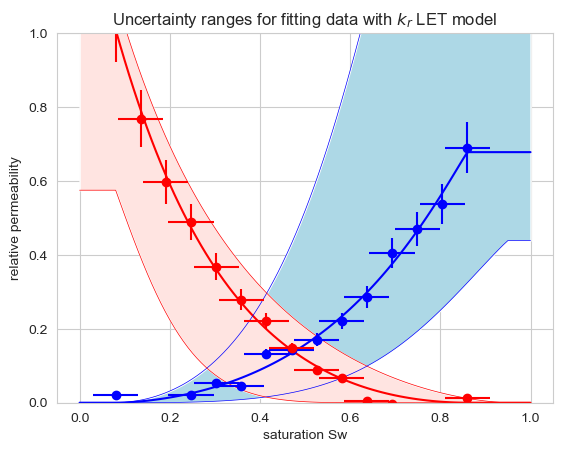

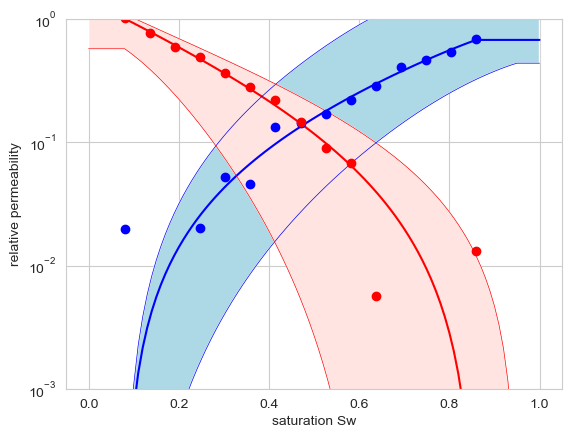

In [18]:

# error ranges for kr

#LETnames=['Swc', 'Sorw', 'krwe', 'kroe', 'Lw', 'Ew', 'Tw', 'Lo', 'Eo', 'To']
#errorsignw=[-1.0,  1.0,    1.0,    1.0,  -1.0,  1.0,  1.0, -1.0,  1.0,  1.0]
#errorsigno=[+1.0, -1.0,    1.0,    1.0,  -1.0,  1.0,  1.0, -1.0,  1.0,  1.0]

LETnames=['Swc', 'Sorw', 'krwe', 'kroe', 'Lw', 'Ew', 'Tw', 'Lo', 'Eo', 'To']
errorsignw=[-1.0,  1.0,    1.0,    1.0,  -1.0,  -1.0,  1.0, -1.0,  -1.0,  1.0]
errorsigno=[+1.0, -1.0,    1.0,    1.0,  -1.0,  -1.0,  1.0, -1.0,  -1.0,  1.0]


result_LET=result_pckr
result_LET.params.pretty_print()

LETfiterror = result_LET.params.copy()
LETfiterrorupw = LETfiterror.copy()
LETfiterrordownw = LETfiterror.copy()
LETfiterrorupo = LETfiterror.copy()
LETfiterrordowno = LETfiterror.copy()

for l in range(len(LETnames)):
    
    stderract = LETfiterror[LETnames[l]].stderr
    if stderract > np.abs(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].min):
       stderract = np.abs(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].min) 
       
    
    #if LETfiterror[LETnames[l]].value+stderract/2 > LETfiterror[LETnames[l]].max:
    #   stderract = 2*(LETfiterror[LETnames[l]].max-LETfiterror[LETnames[l]].value)
    #
    #if LETfiterror[LETnames[l]].value-stderract/2 < LETfiterror[LETnames[l]].min:
    #   stderract = 2*(LETfiterror[LETnames[l]].value-LETfiterror[LETnames[l]].min)
    
    
    LETfiterrorupw[LETnames[l]].value=LETfiterror[LETnames[l]].value+errorsignw[l]*stderract/2
    LETfiterrorupo[LETnames[l]].value=LETfiterror[LETnames[l]].value+errorsigno[l]*stderract/2
    LETfiterrordownw[LETnames[l]].value=LETfiterror[LETnames[l]].value-errorsignw[l]*stderract/2
    LETfiterrordowno[LETnames[l]].value=LETfiterror[LETnames[l]].value-errorsigno[l]*stderract/2
    
    if LETfiterrorupw[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrorupw[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrorupw[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrorupw[LETnames[l]].value = LETfiterror[LETnames[l]].min
        
    if LETfiterrorupo[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrorupo[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrorupo[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrorupo[LETnames[l]].value = LETfiterror[LETnames[l]].min
    
    if LETfiterrordownw[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrordownw[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrordownw[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrordownw[LETnames[l]].value = LETfiterror[LETnames[l]].min
        
    if LETfiterrordowno[LETnames[l]].value > LETfiterror[LETnames[l]].max:
        LETfiterrordowno[LETnames[l]].value = LETfiterror[LETnames[l]].max
    
    if LETfiterrordowno[LETnames[l]].value < LETfiterror[LETnames[l]].min:
        LETfiterrordowno[LETnames[l]].value = LETfiterror[LETnames[l]].min
        
   
 

def params_to_rlpmodel(params ):
        v = params.valuesdict()
        Swc  = v['Swc']
        Sorw = v['Sorw']
        krwe = v['krwe']
        kroe = v['kroe']
        Lw   = v['Lw']
        Ew   = v['Ew']
        Tw   = v['Tw']
        Lo   = v['Lo']
        Eo   = v['Eo']
        To   = v['To']
        rlp_model = rlplib.Rlp2PLET( Swc, Sorw, Lw, Ew, Tw, 
                                     Lo, Eo, To, krwe, kroe)        
        return rlp_model

def params_to_crpmodel(params ):
        v = params.valuesdict()
        Swc  = v['Swc']
        Sorw = v['Sorw']
        Swi  = v['Swi']
        cwi  = v['cwi']
        awi  = v['awi']
        aoi  = v['aoi']
        ci   = v['ci']
        # We take Sorw for Pc to the right of the relperm Sorw
        Sorwi = Sorw - 0.01
        skj_model = Skjaeveland( Swc, Sorwi, Swi, cwi, awi, aoi, ci )
        # We give the Skjaevland Pc model to the simulator as a cubic interpolation model
        EPS = 0.001
        n = 101
        swvi = np.linspace( skj_model.Swc+EPS, 1-Sorwi-EPS, n )
        pcvi = skj_model.calc(swvi)
        cpr_model = rlplib.CubicInterpolator( swvi, pcvi, lex=1, rex=1 )
        return cpr_model



rlp_model3w = params_to_rlpmodel(LETfiterrorupw)
rlp_model3o = params_to_rlpmodel(LETfiterrorupo)
rlp_model4w = params_to_rlpmodel(LETfiterrordownw)
rlp_model4o = params_to_rlpmodel(LETfiterrordowno)

# pc
#crp_model3 = params_to_crpmodel(bestfitparams)


swv = np.linspace(0,1,101)
plt.figure()
plt.plot( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.plot( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.plot( swv, rlp_model3w.calc_kr1(swv), 'b', linewidth=0.5, label='+stderr')
plt.plot( swv, rlp_model3o.calc_kr2(swv), 'r', linewidth=0.5, label='+stderr')
plt.plot( swv, rlp_model4w.calc_kr1(swv), 'b', linewidth=0.5, label='-stderr')
plt.plot( swv, rlp_model4o.calc_kr2(swv), 'r', linewidth=0.5, label='-stderr')
plt.fill_between( swv, rlp_model4w.calc_kr1(swv), rlp_model3w.calc_kr1(swv), facecolor='lightblue', interpolate=True)
plt.fill_between( swv, rlp_model4o.calc_kr2(swv), rlp_model3o.calc_kr2(swv), facecolor='mistyrose', interpolate=True)
#plt.plot( Kr_data.Sat, Kr_data.kr1, 'bo')
plt.errorbar( Kr_data.Sat, Kr_data.kr1, xerr=0.05, yerr=np.abs(Kr_data.kr1*krerrlevel), fmt='o', color='blue', label='krw manual match')
#plt.plot( Kr_data.Sat, Kr_data.kr2, 'ro');
plt.errorbar( Kr_data.Sat, Kr_data.kr2, xerr=0.05, yerr=np.abs(Kr_data.kr2*krerrlevel), fmt='o', color='red', label='kroo manual match')
plt.ylim(0,1)
#plt.legend();
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
plt.title('Uncertainty ranges for fitting data with $k_r$ LET model');
plt.show()

plt.semilogy( swv, rlpmodel_LET_fit.calc_kr1(swv), 'b', label='krw fit')
plt.semilogy( swv, rlpmodel_LET_fit.calc_kr2(swv), 'r', label='kro fit')
plt.semilogy( swv, rlp_model3w.calc_kr1(swv), 'b', linewidth=0.5, label='+stderr')
plt.semilogy( swv, rlp_model3o.calc_kr2(swv), 'r', linewidth=0.5, label='+stderr')
plt.semilogy( swv, rlp_model4w.calc_kr1(swv), 'b', linewidth=0.5, label='-stderr')
plt.semilogy( swv, rlp_model4o.calc_kr2(swv), 'r', linewidth=0.5, label='-stderr')
plt.fill_between( swv, rlp_model4w.calc_kr1(swv), rlp_model3w.calc_kr1(swv), facecolor='lightblue', interpolate=True)
plt.fill_between( swv, rlp_model4o.calc_kr2(swv), rlp_model3o.calc_kr2(swv), facecolor='mistyrose', interpolate=True)
plt.semilogy( Kr_data.Sat, Kr_data.kr1, 'bo')
#plt.errorbar( Kr_data.Sat, Kr_data.kr1, xerr=0.05, yerr=np.abs(Kr_data.kr1*0.1), fmt='o', color='blue', label='krw manual match')
plt.semilogy( Kr_data.Sat, Kr_data.kr2, 'ro');
#plt.errorbar( Kr_data.Sat, Kr_data.kr2, xerr=0.05, yerr=np.abs(Kr_data.kr2*0.1), fmt='o', color='red', label='kroo manual match')

plt.ylim(1E-3,1)
#plt.legend(); 
plt.xlabel('saturation Sw'); plt.ylabel('relative permeability')
#plt.title('Best fit of LET relperms to tabulated kr');
plt.show()



# Plot correlation matrix

C:\Users\Steffen.Berg\AppData\Local\Temp\ipykernel_11420\2660574749.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


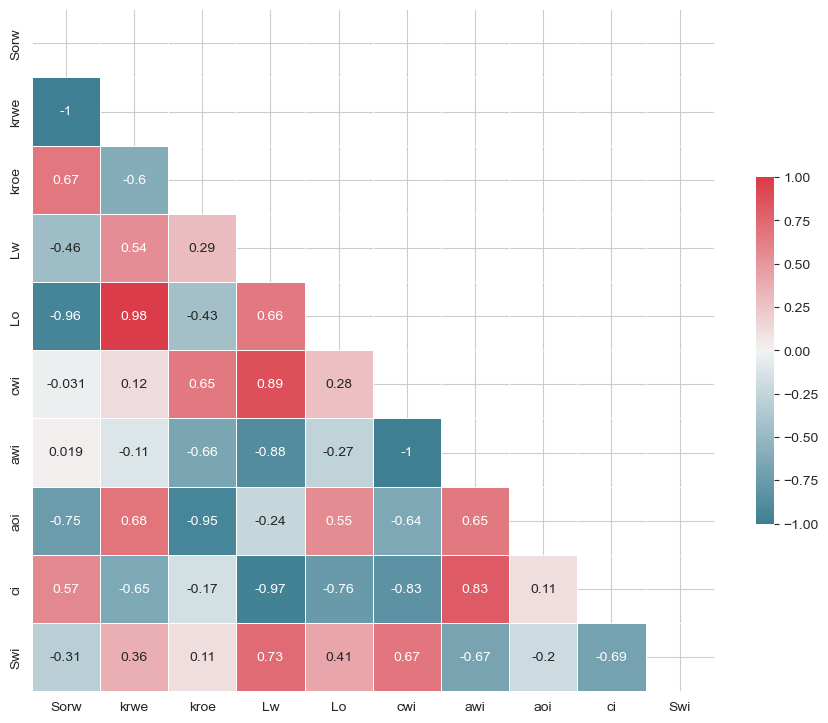

In [19]:

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


correlation=correlation_from_covariance(result_LET.covar)

#LETSKnames=['Swc', 'Sorw', 'krwe', 'kroe', 'Lw', 'Ew', 'Tw', 'Lo', 'Eo', 'To','cwi','awi','aoi','ci','Swi']
LETSKnames=['Sorw', 'krwe', 'kroe', 'Lw', 'Lo', 'cwi','awi','aoi','ci','Swi']  #Swc=fixed

#corr = pd.DataFrame(data=correlation, index=LETnames, columns=LETnames)
corr = pd.DataFrame(data=correlation, index=LETSKnames, columns=LETSKnames)


# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1.0,       # The maximum value of the legend. All higher vals will be same color
    vmin=-1.0,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

fig.show()